In [1]:
import warnings
warnings.filterwarnings("ignore")

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from collections import Counter
from sklearn.svm import SVC
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import Adam
from transformers import get_scheduler
from tqdm import tqdm
from transformers import BertModel, BertTokenizer

### Import data

In [71]:
df = pd.read_csv('firstname_with_sex.csv', sep=';', encoding='utf-8')
df.head()

,firstname,male,female
0,marie,10145,2390322
1,jean,1869615,6476
2,pierre,1475841,5047
3,jeanne,1765,1097397
4,françois,1089009,5951


### Feature engineering

In [72]:
df['male_c'] = df.apply(lambda row: '{:.2f}'.format(row['male']/(row['male']+row['female'])*100), axis = 1)
df['female_c'] = df.apply(lambda row: '{:.2f}'.format(row['female']/(row['male']+row['female'])*100), axis = 1)
df['sex'] = df.apply(lambda row: 1 if row['male']>row['female'] else 0, axis = 1)
df['length'] = df.apply(lambda row: len(row['firstname']), axis = 1)

In [73]:
df['2l'] = df.apply(lambda row: row['firstname'][-2:], axis = 1)
df['1l'] = df.apply(lambda row: row['firstname'][-1], axis = 1)

In [74]:
def compter(prenom):
    voyelles = 0
    consonnes = 0
    for lettre in prenom.lower():
        if lettre in 'aeiouy':
            voyelles += 1
        elif lettre.isalpha():
            consonnes += 1
    return voyelles, consonnes

In [75]:
df['voyelles'], df['consonnes'] = zip(*df['firstname'].apply(compter))

In [76]:
df.head()

,firstname,male,female,male_c,female_c,sex,length,2l,1l,voyelles,consonnes
0,marie,10145,2390322,0.42,99.58,0,5,ie,e,3,2
1,jean,1869615,6476,99.65,0.35,1,4,an,n,2,2
2,pierre,1475841,5047,99.66,0.34,1,6,re,e,3,3
3,jeanne,1765,1097397,0.16,99.84,0,6,ne,e,3,3
4,françois,1089009,5951,99.46,0.54,1,8,is,s,3,5


### Tokenisation

In [77]:
text = ''
for e in df['firstname'].values:
    text += e

In [78]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))

+<>^abcdefghijklmnopqrstuvwxyz~§©âãäçèéêëíîðôöüÿ


In [79]:
chars = ''.join(chars)

In [80]:
chars

'+<>^abcdefghijklmnopqrstuvwxyz~\x87\x8d§©âãäçèéêëíîðôöüÿ'

In [81]:
stoi = { ch:i for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]

In [82]:
df['token'] = df['firstname'].apply(encode)

In [83]:
df.head()

,firstname,male,female,male_c,female_c,sex,length,2l,1l,voyelles,consonnes,token
0,marie,10145,2390322,0.42,99.58,0,5,ie,e,3,2,"[16, 4, 21, 12, 8]"
1,jean,1869615,6476,99.65,0.35,1,4,an,n,2,2,"[13, 8, 4, 17]"
2,pierre,1475841,5047,99.66,0.34,1,6,re,e,3,3,"[19, 12, 8, 21, 21, 8]"
3,jeanne,1765,1097397,0.16,99.84,0,6,ne,e,3,3,"[13, 8, 4, 17, 17, 8]"
4,françois,1089009,5951,99.46,0.54,1,8,is,s,3,5,"[9, 21, 4, 17, 38, 18, 12, 22]"


In [84]:
df['last_2'] = df.apply(lambda row:sum(row['token'][-2:]), axis = 1)
df['last_1'] = df.apply(lambda row:row['token'][-1], axis = 1)
df.head()

,firstname,male,female,male_c,female_c,sex,length,2l,1l,voyelles,consonnes,token,last_2,last_1
0,marie,10145,2390322,0.42,99.58,0,5,ie,e,3,2,"[16, 4, 21, 12, 8]",20,8
1,jean,1869615,6476,99.65,0.35,1,4,an,n,2,2,"[13, 8, 4, 17]",21,17
2,pierre,1475841,5047,99.66,0.34,1,6,re,e,3,3,"[19, 12, 8, 21, 21, 8]",29,8
3,jeanne,1765,1097397,0.16,99.84,0,6,ne,e,3,3,"[13, 8, 4, 17, 17, 8]",25,8
4,françois,1089009,5951,99.46,0.54,1,8,is,s,3,5,"[9, 21, 4, 17, 38, 18, 12, 22]",34,22


# Approche Classique

### Entraînement de modèle

### One Hot encoding

In [85]:
X_train, X_test, y_train, y_test = train_test_split(df[['2l']], df['sex'], test_size=0.33, random_state=42)

encoder = OneHotEncoder(drop='first',sparse_output=False,  handle_unknown='ignore')  
encoder.fit(X_train)

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [86]:
clf1 = LogisticRegression(penalty='l2', C=1, solver='saga')
clf1.fit(X_train, y_train)
y_pred = clf1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}\n')

Accuracy: 0.85



### Utilisation Tokens

In [87]:
feat = df[['last_2', 'length', 'last_1', 'consonnes', 'voyelles']]
label = df['sex']

data = df[['last_2', 'length', 'last_1', 'consonnes', 'voyelles', 'sex']]

X_train,X_test,y_train,y_test= train_test_split(feat, label, test_size =0.2, random_state=42)

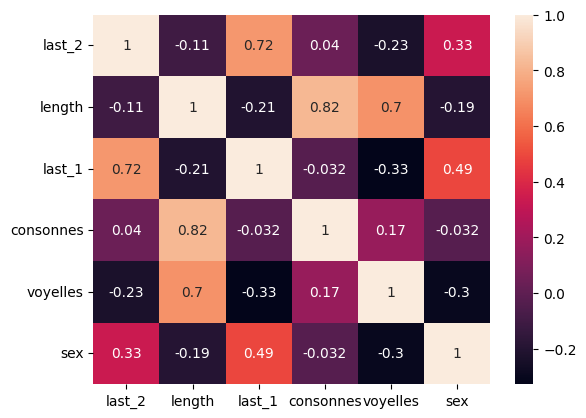

In [88]:
cor = data.corr()
sns.heatmap(cor, annot=True);

In [89]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [90]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}\n')

Accuracy: 0.86



In [91]:
importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': ['last_2', 'length', 'last_1', 'consonnes', 'voyelles'],
    'Importance': importances}).sort_values(by='Importance', ascending=False)

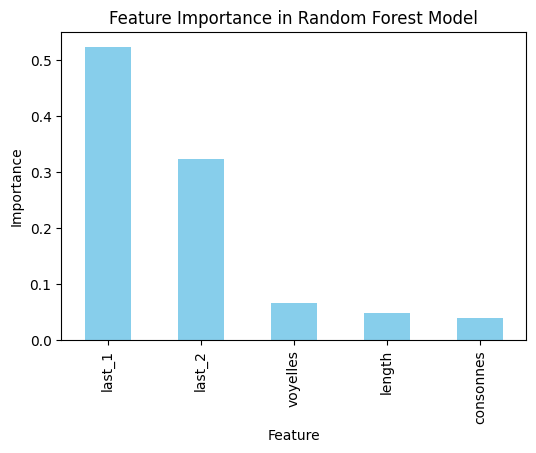

In [92]:
feature_importance_df.set_index('Feature', inplace=True)
feature_importance_df['Importance'].plot(kind='bar', figsize=(6, 4), color='skyblue')
plt.title('Feature Importance in Random Forest Model')
plt.ylabel('Importance')
plt.show()

In [26]:
feat = df[['last_2', 'last_1']]
label = df['sex']

X_train,X_test,y_train,y_test= train_test_split(feat, label, test_size =0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}\n')

Accuracy: 0.85



In [27]:
params = {
    'n_estimators': [10, 50, 100, 200], 
    'max_features': ['auto', 'sqrt', 'log2'],  
    'max_depth' : [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4], 
    'bootstrap': [True, False] 
}

clf = RandomForestClassifier()

# Création de la recherche sur grille avec validation croisée
grid = GridSearchCV(estimator = clf, param_grid = params, 
                           cv = 3, n_jobs = -1, verbose = 1, scoring='accuracy')


In [28]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [29]:
clf = grid.best_estimator_

predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       721
           1       0.86      0.82      0.84       669

    accuracy                           0.85      1390
   macro avg       0.85      0.85      0.85      1390
weighted avg       0.85      0.85      0.85      1390



In [30]:
params = {
    'max_depth': [3, 5, 7], 
    'n_estimators': [50, 100, 200], 
    'learning_rate': [0.01, 0.1, 0.2],
}

grid = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
                           params, scoring='accuracy', cv=3)


grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [32]:
clf = grid.best_estimator_

predictions = clf.predict(X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       721
           1       0.87      0.82      0.84       669

    accuracy                           0.85      1390
   macro avg       0.85      0.85      0.85      1390
weighted avg       0.85      0.85      0.85      1390



# Embedding

In [33]:
# padding pour avoir même longueur
df['token'] = df.apply(lambda row:row['token'] + [0]*(35 - len(row['token'])), axis = 1)  

In [34]:
class TextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = [torch.tensor(s) for s in sequences]
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [35]:
df_train,df_test= train_test_split(df, test_size =0.2, random_state=42)

In [36]:
dataset_train = TextDataset(df_train['token'].tolist(), torch.tensor(df_train['sex'].tolist()))
dataset_test = TextDataset(df_test['token'].tolist(), torch.tensor(df_test['sex'].tolist()))
# Padding des séquences dans le collate_fn
def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = torch.stack(sequences) 
    labels = torch.stack(labels)
    return sequences_padded, labels


# DataLoader
batch_size = 16
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn)

In [37]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.embedding(x)
        x, (hidden, _) = self.lstm(x)
        x = hidden[-1]
        x = self.fc(x)
        return self.activation(x)

# Modèle
vocab_size = 50
model = TextClassifier(vocab_size=50, embed_dim=50, hidden_dim=100, num_classes=1)

# Fonction de perte et optimiseur
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [39]:
def train_model(model, dataloader, optimizer, criterion, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        true_labels = []
        pred_labels = []
        
        for sequences, labels in tqdm(dataloader):
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            true_labels.extend(labels.tolist())
            pred_labels.extend(torch.round(outputs).squeeze().tolist())
        
        epoch_loss = total_loss / len(dataloader)
        epoch_acc = accuracy_score(true_labels, pred_labels)

# Appel de la fonction d'entraînement
train_model(model, dataloader_train, optimizer, criterion, num_epochs=15)

100%|██████████| 348/348 [00:06<00:00, 57.96it/s]


In [40]:
def evaluate_model(model, dataloader_test):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for sequences, labels in dataloader_test:

            outputs = model(sequences)
            predicted_labels = torch.round(outputs.squeeze()) if outputs.shape[1] == 1 else torch.argmax(outputs, dim=1)
            all_predictions.extend(predicted_labels.numpy())
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    
    class_report = classification_report(all_labels, all_predictions, target_names=['Classe 0', 'Classe 1'])
    
    return accuracy, class_report

accuracy, class_report = evaluate_model(model, dataloader_test)
print("Accuracy:", accuracy)
print("Classification Report:\n", class_report)

Accuracy: 0.8906474820143885
Classification Report:
               precision    recall  f1-score   support

    Classe 0       0.90      0.88      0.89       721
    Classe 1       0.88      0.90      0.89       669

    accuracy                           0.89      1390
   macro avg       0.89      0.89      0.89      1390
weighted avg       0.89      0.89      0.89      1390



# Approch avec LLM

In [43]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Freeze les paramètres BERT 
for param in model.parameters():
    param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [44]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)

        return encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0), labels

In [45]:
def extract_features(data_loader, model):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for input_ids, attention_mask, label in tqdm(data_loader):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            label = torch.Tensor(label)
            output = model(input_ids, attention_mask=attention_mask)
            features.extend(output.last_hidden_state[:,0,:].detach().cpu().numpy())
            labels.extend(label.numpy())

    return features, labels

In [46]:
texts = df['firstname'].tolist()
labels = df['sex'].tolist()


dataset = TextDataset(texts, labels, tokenizer)
loader = torch.utils.data.DataLoader(dataset, batch_size=16)

# Extract features
features, labels = extract_features(loader, model)

100%|██████████| 435/435 [05:56<00:00,  1.22it/s]


In [47]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

print("Accuracy:", clf.score(X_test, y_test))

Accuracy: 0.8468624064478987


In [48]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

print("Accuracy:", clf.score(X_test, y_test))

Accuracy: 0.8526194588370755


In [49]:
params = {
    'max_depth': [3, 5, 7],  
    'n_estimators': [50, 100, 200],  
    'learning_rate': [0.01, 0.1, 0.2]}

grid = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
                                       params, scoring='accuracy', cv=3)

grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [50]:
clf = grid.best_estimator_
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       913
           1       0.87      0.87      0.87       824

    accuracy                           0.88      1737
   macro avg       0.88      0.88      0.88      1737
weighted avg       0.88      0.88      0.88      1737



### Test Data

In [59]:
df1 = pd.read_csv('transcriptions_with_sex.csv')
data = df1[['prediction', 'sex']]

In [60]:
# Nettoyer et extraire les mots
def split(text):
    text = ''.join([char.lower() for char in text])
    return text.split()

word_counts = Counter()
data['prediction'].apply(lambda x: word_counts.update(split(x)))

most_common_words = word_counts.most_common(6)  

In [61]:
def extraire_valeurs(phrase):
    valeurs = {}
    mots = phrase.split()
    for i in range(len(mots)):
        mot = mots[i]
        if mot.endswith(':'):
            for mot_tuple in most_common_words:
                if mot_tuple[0] == mot:
                    if i + 1 < len(mots):
                        valeurs[mot[:-1]] = mots[i+1]
                    else:
                        valeurs[mot[:-1]] = None
                    break
    return valeurs

In [62]:
data['valeurs'] = data['prediction'].apply(extraire_valeurs)
features = pd.DataFrame(data['valeurs'].tolist())
features = features[['nom', 'prénom', 'relation', 'profession']]
features['sex'] = data['sex']
features['sex'] = features['sex'].replace({'homme': 1, 'femme': 0, 'ambigu':0})

In [63]:
features.head()

,nom,prénom,relation,profession,sex
0,Chardon,Marie,NaN,NaN,0
1,Lhopital,Louis,NaN,NaN,1
2,Pyrin,Marie,d,NaN,0
3,Lavocat,Marie,NaN,'',0
4,Benne,Marguerite,'',NaN,0


In [65]:
texts = features['prénom'].tolist()
labels = features['sex'].tolist()

dataset = TextDataset(texts, labels, tokenizer)
loader = torch.utils.data.DataLoader(dataset, batch_size=8)

features, labels = extract_features(loader, model)

100%|██████████| 31/31 [00:11<00:00,  2.59it/s]


In [66]:
predictions = clf.predict(features)
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       116
           1       0.94      0.94      0.94       125

    accuracy                           0.94       241
   macro avg       0.94      0.94      0.94       241
weighted avg       0.94      0.94      0.94       241



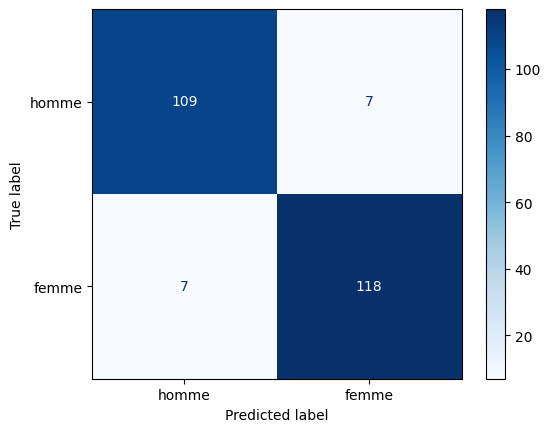

In [69]:
cm = confusion_matrix(labels, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['homme', 'femme'])
disp.plot(cmap = 'Blues');